In [2]:
import os
import logging
import glob
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.utils import data
from torchvision import transforms
import lmdb
import pickle
import string
import random




# Data Loader

In [4]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class ImagesDataset(data.Dataset):
    def __init__(self, dataset_folder="data/comprehensive_cars/images/*.jpg", size=64):
        self.size = size
        "Resize Image and only apply Horizontal Flip augmentation method"
        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),            
        ])
        self.data_type = os.path.basename(dataset_folder).split(".")[-1]
        
        import time
        t0 = time.time()
        print('Start loading file addresses ...')
        images = glob.glob(dataset_folder)
        random.shuffle(images)
        t = time.time() - t0
        print('done! time:', t)
        print("Number of images found: %d" % len(images))
        
        self.images = images
        self.length = len(images)
    
    def __getitem__(self, idx):
        try:
            buf = self.images[idx]
            if self.data_type == 'npy':
                img = np.load(buf)[0].transpose(1, 2, 0)
                img = Image.fromarray(img).convert("RGB")
            else:
                img = Image.open(buf).convert('RGB')

            img = self.transform(img)
            data = {
                'image': img
            }
            return data
        
        except Exception as e:
            print(e)
            print("Warning: Error occurred when loading file %s" % buf)
            return self.__getitem__(np.random.randint(self.length))

    def __len__(self):
        return self.length
        

Start loading file addresses ...
done! time: 1.8548851013183594
Number of images found: 136726


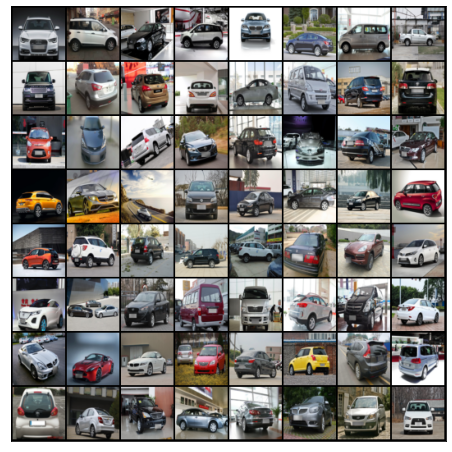

In [19]:
## PLOT IMAGES FROM DATASET

batch_size = 64
n_workers = 8

cars_dataset = ImagesDataset()
cars_loader = torch.utils.data.DataLoader(
    cars_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True,
    pin_memory=True, drop_last=True,
)

from torchvision.utils import make_grid
from torchvision.utils import save_image


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

for batch in cars_loader:
    temp_batch = batch["image"]
    show_images(temp_batch)
    break

# Decoder
Predicts volume density and color from 3D location, viewing direction, and latent code z

Parameterize the object and background feature fields with multi-layer perceptrons (MLPs) which take as input a 3D point x and viewing direction d together with latent shape and appearance codes $z_s, z_a$ and output a density $\sigma$ and feature $f$. More specifically, we apply the positional encoding $\gamma (x)$ and the latent sahape code $z_s$/ This is followed by blocks of fully-connected layes with ReLU activation. We use 8 blocks with a hidden dimenstion of 128 and one skip connection to the fourth layer for the object feature field, and 4 blocks with a hidden dimension of 64 for the background feature field. We then project this to the first output, the one-dimensional density output $\sigma$/ In a second branch, we apply the positional encoding $\gamma$ to the viewing direction $d$, concatenate $\gamma(d)$ to thee latent appearence code $z_a$, and add it to the previous hidden features. We pass it through a single fully-coinnected layer with ReLU activation and project it to the second output $f$.

In [64]:
class Decoder(nn.Module):
    def __init__(self, hidden_size=128, n_blocks=8, n_blocks_view=1,
                skips=[4], n_freq_posenc=10, n_freq_posenc_views=4, 
                z_dim=64, rgb_out_dim=128, downscale_p_by=2, **kwargs):
        super().__init__()
        self.downscale_p_by = downscale_p_by                  # downscale factor for input points before positional encdoing
        
        # positional encoding
        self.n_freq_posenc = n_freq_posenc                    # max freq for positional encoding of 3D Location
        self.n_freq_posenc_views = n_freq_posenc_views        # max freq for positional encoding of viewing direction
        dim_embed = 3 * self.n_freq_posenc * 2                # Size of Positional Encoded 3D Location
        dim_embed_view = 3 * self.n_freq_posenc_views * 2     # Size of Positional Encoded Viewing Direction   
        
        ## Density Prediciton Layers
        self.n_blocks = n_blocks                              # Number of Layers
        self.hidden_size = hidden_size                        # hidden size of Decoder Network
        self.z_dim = z_dim                                    # Dimension of latent code z        
        
        self.fc_in = nn.Linear(dim_embed, hidden_size)        # Input r(x) Positional Encoded 3D Location
        self.fc_z = nn.Linear(self.z_dim, hidden_size)        # Input z_s = latent shape code
        self.blocks = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for i in range(self.n_blocks - 1)       # MLP Layers for Density Prediction
        ])
        
        ### Skip Connection
        self.skips = skips                                    # where to add a skip connection
        n_skips = sum([i in skips for i in range(n_blocks - 1)])
        if n_skips > 0:
            self.fc_z_skips = nn.ModuleList(
                [nn.Linear(z_dim, hidden_size) for i in range(n_skips)]
            )
            self.fc_p_skips = nn.ModuleList([
                nn.Linear(dim_embed, hidden_size) for i in range(n_skips)
            ])
        
        ### Volume Density
        self.sigma_out = nn.Linear(hidden_size, 1)            # Output sigma (Volume Density)  at 8th Layer Before adding Direction
        
        ## Feature Prediction Layers
        self.n_blocks_view = n_blocks_view                    # Number of View-dep Layers
        self.rgb_out_dim = rgb_out_dim                        # Output Dimension of Feature Prediction
        
        self.fc_z_view = nn.Linear(self.z_dim, hidden_size)   # Input z_a = latent appearance code
        self.feat_view = nn.Linear(hidden_size, hidden_size)  # Input Density Prediction FC
        self.fc_view = nn.Lienar(dim_embed_view, hidden_size) # Input r(d) Positional Encoded Viewing Direction
        self.feat_out = nn.Linear(hidden_size, rgb_out_dim)   # Output Feature Vector
        
        
    def transform_points(self, p, views_False, downscale_p_by = 2):
        ##Positional Encoding of 3D Location and Viewing Direction
        p = p / downscale_p_by                                # Normalize p between [-1, 1] 
        
        '''
        n_freq_posenc (int), max freq for positional encdoing of 3D Location,
        n_freq_posenc_views (int), max freq for positional encoding of Viewing Direction
        ''' 
        L = self.n_freq_posenc_views if views else self.n_freq_posenc 
        p_transformed = torch.cat([torch.cat(
            [torch.sin((2 ** i) * np.pi * p),
             torch.cos((2 ** i) * np.pi * p)],
            dim=-1) for i in range(L)], dim = 1)
        
        return p_transformed
    
    def forward(self, p_in, ray_d, z_shape=None, z_app=None, **kwargs):
        a = F.relu
        if self.z_dim > 0:
            batch_size = p_in.shape[0]
            if z_shape is None:
                z_shape = torch.randn(batch_size, self.z_dim).to(p_in.device)
            if z_app is None:
                z_app = torch.randn(batch_size, self.z_dim).to(p_in.device)
        p = self.transform_points(p_in)
        net = self.fc_in(p)
        net = net + self.fc_z(z_shape).unsqueeze(1)
        net = a(net)
        
        skip_idx = 0
        for idx, layer in enumerate(self.blocks):
            net = a(layer(net))
            if (idx+1) in self.skips and (idx < len(self.blocks) -1):   # add skip connection
                net = net + self.fc_z_skips[skip_idx](z_shape).unsqueeze(1)
                net = net + self.fc_p_skips[skip_idx](p)
                skip_idx += 1
        sigma_out = self.sigma_out(net).squeeze(-1)
        
        net = self.feat_view(net)
        net = net + self.fc_z_view(z_app).unsqueeze(1)
        
        ray_d = ray_d / torch.norm(ray_d, dim=-1, keepdim=True)
        ray_d = self.transform_points(ray_d, views=True)
        net = net + self.fc_view(ray_d)
        net = a(net)
        if self.n_blocks_view > 1:
            for layer in self.blocks_view:
                net = a(layer(net))
        feat_out = self.feat_out(net)
        
        return feat_out, sigma_out

# Bounding Box Generator
Object Detection is used to predict how many objects are there. 

In [58]:
import numpy as np
import torch.nn as nn
import torch
from scipy.spatial.transform import Rotation as Rot
from im2scene.camera import get_rotation_matrix

In [59]:
class BoundingBoxGenerator(nn.Module):
    ''' Bounding box generator class

    Args:
        n_boxes (int): number of bounding boxes (excluding background)
        scale_range_min (list): min scale values for x, y, z
        scale_range_max (list): max scale values for x, y, z
        translation_range_min (list): min values for x, y, z translation
        translation_range_max (list): max values for x, y, z translation
        z_level_plane (float): value of z-plane; only relevant if
            object_on_plane is set True
        rotation_range (list): min and max rotation value (between 0 and 1)
        check_collision (bool): whether to check for collisions
        collision_padding (float): padding for collision checking
        fix_scale_ratio (bool): whether the x/y/z scale ratio should be fixed
        object_on_plane (bool): whether the objects should be placed on a plane
            with value z_level_plane
        prior_npz_file (str): path to prior npz file (used for clevr) to sample
            locations from
    '''

    def __init__(self, n_boxes=1,
                 scale_range_min=[0.5, 0.5, 0.5],
                 scale_range_max=[0.5, 0.5, 0.5],
                 translation_range_min=[-0.75, -0.75, 0.],
                 translation_range_max=[0.75, 0.75, 0.],
                 z_level_plane=0., rotation_range=[0., 1.],
                 check_collison=False, collision_padding=0.1,
                 fix_scale_ratio=True, object_on_plane=False,
                 prior_npz_file=None, **kwargs):
        super().__init__()

        self.n_boxes = n_boxes
        self.scale_min = torch.tensor(scale_range_min).reshape(1, 1, 3)
        self.scale_range = (torch.tensor(scale_range_max) -
                            torch.tensor(scale_range_min)).reshape(1, 1, 3)

        self.translation_min = torch.tensor(
            translation_range_min).reshape(1, 1, 3)
        self.translation_range = (torch.tensor(
            translation_range_max) - torch.tensor(translation_range_min)
        ).reshape(1, 1, 3)

        self.z_level_plane = z_level_plane
        self.rotation_range = rotation_range
        self.check_collison = check_collison
        self.collision_padding = collision_padding
        self.fix_scale_ratio = fix_scale_ratio
        self.object_on_plane = object_on_plane

        if prior_npz_file is not None:
            try:
                prior = np.load(prior_npz_file)['coordinates']
                # We multiply by ~0.23 as this is multiplier of the original clevr
                # world and our world scale
                self.prior = torch.from_numpy(prior).float() * 0.2378777237835723
            except Exception as e: 
                print("WARNING: Clevr prior location file could not be loaded!")
                print("For rendering, this is fine, but for training, please download the files using the download script.")
                self.prior = None
        else:
            self.prior = None

    def check_for_collison(self, s, t):
        n_boxes = s.shape[1]
        if n_boxes == 1:
            is_free = torch.ones_like(s[..., 0]).bool().squeeze(1)
        elif n_boxes == 2:
            d_t = (t[:, :1] - t[:, 1:2]).abs()
            d_s = (s[:, :1] + s[:, 1:2]).abs() + self.collision_padding
            is_free = (d_t >= d_s).any(-1).squeeze(1)
        elif n_boxes == 3:
            is_free_1 = self.check_for_collison(s[:, [0, 1]], t[:, [0, 1]])
            is_free_2 = self.check_for_collison(s[:, [0, 2]], t[:, [0, 2]])
            is_free_3 = self.check_for_collison(s[:, [1, 2]], t[:, [1, 2]])
            is_free = is_free_1 & is_free_2 & is_free_3
        else:
            print("ERROR: Not implemented")
        return is_free

    def get_translation(self, batch_size=32, val=[[0.5, 0.5, 0.5]]):
        n_boxes = len(val)
        t = self.translation_min + \
            torch.tensor(val).reshape(1, n_boxes, 3) * self.translation_range    # compute translation parameters element-wise(x,y,z)
        t = t.repeat(batch_size, 1, 1)
        if self.object_on_plane:
            t[..., -1] = self.z_level_plane
        return t          # return translation parameters for each 


    def get_rotation(self, batch_size=32, val=[0.]):
        r_range = self.rotation_range
        values = [r_range[0] + v * (r_range[1] - r_range[0]) for v in val]
        # compute rotation value for all objects. (0 <= v <= 1, therefore the result is in the range)
        r = torch.cat([get_rotation_matrix(
            value=v, batch_size=batch_size).unsqueeze(1) for v in values],
            dim=1)
        r = r.float()
        return r    # return rotation matrices for each object


    def get_scale(self, batch_size=32, val=[[0.5, 0.5, 0.5]]):
        n_boxes = len(val)
        if self.fix_scale_ratio:
            t = self.scale_min + \
                torch.tensor(val).reshape(
                    1, n_boxes, -1)[..., :1] * self.scale_range
        else:
            t = self.scale_min + \
                torch.tensor(val).reshape(1, n_boxes, 3) * self.scale_range
        t = t.repeat(batch_size, 1, 1)
        return t

    def get_random_offset(self, batch_size):
        n_boxes = self.n_boxes
        # Sample sizes
        if self.fix_scale_ratio:
            s_rand = torch.rand(batch_size, n_boxes, 1)
        else:
            s_rand = torch.rand(batch_size, n_boxes, 3)
        s = self.scale_min + s_rand * self.scale_range

        # Sample translations
        if self.prior is not None:
            idx = np.random.randint(self.prior.shape[0], size=(batch_size))
            t = self.prior[idx]
        else:
            t = self.translation_min + \
                torch.rand(batch_size, n_boxes, 3) * self.translation_range
            if self.check_collison:
                is_free = self.check_for_collison(s, t)
                while not torch.all(is_free):
                    t_new = self.translation_min + \
                        torch.rand(batch_size, n_boxes, 3) * \
                        self.translation_range
                    t[is_free == 0] = t_new[is_free == 0]
                    is_free = self.check_for_collison(s, t)
            if self.object_on_plane:
                t[..., -1] = self.z_level_plane

        def r_val(): return self.rotation_range[0] + np.random.rand() * (
            self.rotation_range[1] - self.rotation_range[0])
        R = [torch.from_numpy(
            Rot.from_euler('z', r_val() * 2 * np.pi).as_dcm())
            for i in range(batch_size * self.n_boxes)]
        R = torch.stack(R, dim=0).reshape(
            batch_size, self.n_boxes, -1).cuda().float()
        return s, t, R

    def forward(self, batch_size=32):
        s, t, R = self.get_random_offset(batch_size)
        R = R.reshape(batch_size, self.n_boxes, 3, 3)
        return s, t, R     # return scale parameters for each object(box)
    


# Neural Renderer

In [71]:
import torch.nn as nn
import torch
from math import log2
from im2scene.layers import Blur

In [72]:
class NeuralRenderer(nn.Module):
    def __init__(
            self, n_feat=128, input_dim=128, out_dim=3, 
            min_feat=32, img_size=64, use_rgb_skip=True,
            upsample_feat="nn", upsample_rgb="bilinear",
            **kwargs):
        super().__init__()
        self.input_dim = input_dim             # input dimension, should be same as n_features
        self.use_rgb_skip = use_rgb_skip       # option to use RGB skip connections
        n_blocks = int(log2(img_size) - 4)     

        assert(upsample_feat in ("nn", "bilinear"))
        if upsample_feat == "nn":
            self.upsample_2 = nn.Upsample(scale_factor=2.)
        elif upsample_feat == "bilinear":
            self.upsample_2 = nn.Sequential(nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=False), Blur())

        assert(upsample_rgb in ("nn", "bilinear"))
        if upsample_rgb == "nn":
            self.upsample_rgb = nn.Upsample(scale_factor=2.)
        elif upsample_rgb == "bilinear":
            self.upsample_rgb = nn.Sequential(nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=False), Blur())

        if n_feat == input_dim:
            self.conv_in = lambda x: x
        else:
            self.conv_in = nn.Conv2d(input_dim, n_feat, 1, 1, 0)

        self.conv_layers = nn.ModuleList(
            [nn.Conv2d(n_feat, n_feat // 2, 3, 1, 1)] +
            [nn.Conv2d(max(n_feat // (2 ** (i + 1)), min_feat),
                       max(n_feat // (2 ** (i + 2)), min_feat), 3, 1, 1)
                for i in range(0, n_blocks - 1)]
        )
        if use_rgb_skip:
            self.conv_rgb = nn.ModuleList(
                [nn.Conv2d(input_dim, out_dim, 3, 1, 1)] +
                [nn.Conv2d(max(n_feat // (2 ** (i + 1)), min_feat),
                           out_dim, 3, 1, 1) for i in range(0, n_blocks)]
            )
        else:
            self.conv_rgb = nn.Conv2d(
                max(n_feat // (2 ** (n_blocks)), min_feat), 3, 1, 1)

        self.actvn = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        net = self.conv_in(x)

        if self.use_rgb_skip:
            rgb = self.upsample_rgb(self.conv_rgb[0](x))

        for idx, layer in enumerate(self.conv_layers):
            hid = layer(self.upsample_2(net))
            net = self.actvn(hid)

            if self.use_rgb_skip:
                rgb = rgb + self.conv_rgb[idx + 1](net)
                if idx < len(self.conv_layers) - 1:
                    rgb = self.upsample_rgb(rgb)

        if not self.use_rgb_skip:
            rgb = self.conv_rgb(net)

        rgb = torch.sigmoid(rgb)
        return rgb

# Generator

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from scipy.spatial.transform import Rotation as Rot

In [76]:
from im2scene.common import arange_pixels, image_points_to_world, origin_to_world
from im2scene.camera import get_camera_mat, get_random_pose, get_camera_pose

class Generator(nn.Module):
    def __init__(self, z_dim=256, z_dim_bg = 128,
                range_u=(0, 0), range_v=(0.25, 0.25), n_ray_samples=64, 
                resolution_vol=16, fov=49.13, 
                range_radius=(2.732, 2.732), depth_range=[0.5, 6.], background_rotation_range=[0., 0.]):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.n_ray_samples = n_ray_samples                   # Number of samples per ray (= N_s)
        self.range_u = range_u                               # rotation range
        self.range_v = range_v                               # elevation range
        self.resolution_vol = resolution_vol                 # resolution of volume-rendered image
        self.fov = fov                                       # field of view
        self.z_dim = z_dim                                   # dimension of latent code z
        self.z_dim_bg = z_dim_bg                             # dimension of background latent code z_bg
        
        self.range_radius = range_radius                     # radius range
        self.depth_range = depth_range                       # near and far depth plane (t_n, t_f)
        self.bg_rotation_range = background_rotation_range   # background rotation range
        
        self.camera_matrix = get_camera_mat(fov=fov).to(self.device)
        '''
        camera matrix is a matrix which descirbes the mapping of a pinhole camera
        from 3D points in the world to 2D points in an image
        '''
        
    
        self.decoder = Decoder().to(self.device)
        self.background_generator = Decoder(hidden_size = 64, n_blocks = 4, downscale_p_by = 12, skips = []).to(self.device)
        self.bounding_box_generator = BoundingBoxGenerator().to(self.device)
        self.neural_renderer = NeuralRenderer().to(self.device)
    
    def forward(self, batch_size=32, latent_codes=None, camera_matrices=None,
                transformations=None, bg_rotation=None, mode="training", it=0,
                return_alpha_map=False):
        
        if latent_codes is None:
            '''
            Latent Codes are sampled from N(0, I)
            1) z_shape_obj: z_s for object latent shape code
            2) z_app_obj: z_a for object latent appearance code
            3) z_shape_bg: z_s for background latent shape code
            4) z_app_obj: z_a for object latent appearance code
            '''
            n_boxex = self.get_n_boxes()
            z_shape_obj = torch.randn((batch_size, n_boxes, self.z_dim)).to(self.device)
            z_app_obj = torch.randn((batch_size, n_boxes, self.z_dim)).to(self.device)
            z_shape_bg = torch.randn((batch_size, self.z_dim_bg)).to(self.device)
            z_app_bg = torch.randn((batch_size, self.z_dim_bg)).to(self.device)
            latent_codes = (z_shape_obj, z_app_obj, z_shape_bg, z_app_bg)

        if camera_matrices is None:
            '''
            Camera Intrinsics
            Camera Pose ξ is sampled from p_ξ: Uniform distributions over dataset-dependent camera elevation angles
            define the camera to be on a sphere with radius 2.732, and use t_n=0.5 and t_f=6             
            '''
            
            camera_mat = self.camera_matrix.repeat(batch_size, 1, 1)      # size (32, 4, 4)
            world_mat = get_random_pose(self.range_u, self.range_v, self.range_radius, batch_size).to(self.device)          # size (32, 4, 4)
            camera_matrices = (camera_mat, world_mat)

        if transformations is None:
            '''
            Affine Transformation is used to transform points from object to scene space.
            Sampled from p_T: uniform distributions over valid object transformations
            s = scale parameter
            t = translation parameter
            R = rotation matrix
            k(x) = R * [s] * x + t   
            '''
            s, t, R = self.bounding_box_generator(batch_size)
            s, t, R = s.to(self.device), t.to(self.device), R.to(self.device)
            transformations = (s, t, R)

        if bg_rotation is None:
            '''
            Same representation for the background as for objects
            but fix the scale and translation parameters s_N and t_N to span the entire scene and centered in origin
            '''
            if self.backround_rotation_range != [0., 0.]:
                bg_r = self.backround_rotation_range
                r_random = bg_r[0] + np.random.rand() * (bg_r[1] - bg_r[0])
                R_bg = [
                    torch.from_numpy(Rot.from_euler(
                        'z', r_random * 2 * np.pi).as_dcm()
                    ) for i in range(batch_size)]
                R_bg = torch.stack(R_bg, dim=0).reshape(
                    batch_size, 3, 3).float()
            else:
                R_bg = torch.eye(3).unsqueeze(0).repeat(batch_size, 1, 1).float()
            R_bg = R_bg.to(self.device)
            bg_rotation = R_bg

        if return_alpha_map:
            rgb_v, alpha_map = self.volume_render_image(
                latent_codes, camera_matrices, transformations, bg_rotation,
                mode=mode, it=it, return_alpha_map=True,
                not_render_background=not_render_background)
            return alpha_map
        else:
            rgb_v = self.volume_render_image(
                latent_codes, camera_matrices, transformations, bg_rotation,
                mode=mode, it=it, not_render_background=not_render_background,
                only_render_background=only_render_background)
            if self.neural_renderer is not None:
                rgb = self.neural_renderer(rgb_v)
            else:
                rgb = rgb_v
            return rgb
        

    
    
        
    def volume_render_image(self, latent_codes, camera_matrices, 
                            transformations, bg_rotation, mode= "training",
                            it=0, return_alpha_map=False):
        res = self.resolution_vol                                                           #
        device = self.device
        n_steps = self.n_ray_samples
        n_points = res * res
        depth_range = self.depth_range
        batch_size = latent_codes[0].shape[0]
        z_shape_obj, z_app_obj, z_shape_bg, z_app_bg = latent_codes
        
        # Arrange Pixels
        '''
        function: arrange_pixels
        Returns the Tupe of [0] Unscaled pixel locations as integers and [1] scaled float values
        Then change order of the y axis of each scaled float value.
        '''
        pixels = arange_pixels((res, res), batch_size, invert_y_axis=False)[1].to(device)  # Tensor [batch_size, res**2, 2]
        pixels[..., -1] *= -1.  
        
        # Project to 3D world
        '''
        image_points_to_world
        Transforms points on image plane to world coordinates. Fixed Depth of 1
        
        origin_to_world
        Transforms origin (camera location) to world coordinates.
        ''' 
        pixels_world = image_points_to_world(
            pixels, camera_mat=camera_matrices[0], world_mat=camera_matrixes[1]
        )
        camera_world = origin_to_world(
            n_points, camera_mat = camera_matrices[0], world_mat=camera_matrices[1]         
        )
        ray_vector = pixels_world - camera_world
        
        # batch_size x n_points x n_steps
        di = depth_range[0] + torch.linspace(0., 1., steps=n_steps).reshape(1, 1, -1) * (
            depth_range[1] - depth_range[0])
        di = di.repeat(batch_size, n_points, 1).to(device)
        if mode == "training":
            di = self.add_noise_to_interval(di)
            
        n_boxes = letent_codes[0].shape[1]
        feat, sigma = [], []   # feature, sigma for each object
        n_iter = n_boxes + 1
        for i in range(n_iter):
            if i < n_boxes:   # Object
                '''
                p_i = input point x = (x, y, z)
                r_i = viewing direction d 
                sigma_i = shape code
                feat_i = appearance code
                '''
                p_i, r_i = self.get_evaluation_points(pixels_world, camera_world, di, transformations, i)
                z_shape_i, z_app_i = z_shape_obj[:, i], z_app_obj[:, i]
                
                feat_i, sigma_i = self.decoder(p_i, r_i, z_shape, z_app_i)    #Decoder: Obtain feature (128 vector) and density(scalar)
                if mode == "training":
                    sigma_i += torch.randn_like(sigma_i)                      # add noise during training
                    
                # Mask out values outside
                padd = 0.1
                mask_box = torch.all(p_i <=1. + padd, dim=-1) & torch.all(p_i >= -1.-padd, dim =-1)
                sigma_i[mask_box == 0] = 0.
                
                #Reshape 
                sigma_i = sigma_i.reshape(batch_size, n_points, n_steps)     # shape = (32, 256, 64)
                feat_i = feat_i.reshape(batch_size, n_points, n_steps, -1)   # shape = (32, 256, 64, 128)
                
            else: # Background
                p_bg, r_bg = self.get_evaluation_points_bg(
                    pixels_world, camera_world, di, bg_rotation)

                feat_i, sigma_i = self.background_generator(
                    p_bg, r_bg, z_shape_bg, z_app_bg)
                sigma_i = sigma_i.reshape(batch_size, n_points, n_steps)
                feat_i = feat_i.reshape(batch_size, n_points, n_steps, -1)

                if mode == 'training':
                    sigma_i += torch.randn_like(sigma_i)                      # add noise during training
            
            feat.append(feat_i)
            sigma.append(sigma_i)
        sigma = F.relu(torch.stack(sigma, dim=0))
        feat = torch.stack(feat, dim=0)
        
        # Composition Operator
        '''
        When Combining non-solid objects,  sum up individual densites and use the density-weighted mean to combine all features at (x, d)
        '''
        denom_sigma = torch.sum(sigma, dim=0, keepdim=True)
        denom_sigma[denom_sigma == 0] = 1e-4
        w_sigma = sigma / denom_sigma
        sigma_sum = torch.sum(sigma, dim=0)
        feat_weighted = (feat * w_sigma.unsqueeze(-1)).sum(0)
        
        # Get Volume Weights
        weights = self.calc_volume_weights(di, ray_vector, sigma_sum)
        feat_map = torch.sum(weights.unsqueeze(-1) * feat_weighted, dim=-2)      # f = sum(gamma_j * alpha_j  * feature_j)
        
        # Reformat Output
        feat_map = feat_map.permute(0, 2, 1).reshape(
            batch_size, -1, res, res)                # Batch x features x h x w
        feat_map = feat_map.permute(0, 1, 3, 2)      # new to flip x/y
        
        return feat_map
        
        
            
    '''
    _______________________________________________________________________________________________
    _______________________________________________________________________________________________
    _______________________________________________________________________________________________
    '''
    def calc_volume_weights(self, z_vals, ray_vector, sigma, last_dist=1e10):
        dists = z_vals[..., 1:] - z_vals[..., :-1]                          # delta_j: distance between neigboring sample points
        dists = torch.cat([dists, torch.ones_like(
            z_vals[..., :1]) * last_dist], dim=-1)
        dists = dists * torch.norm(ray_vector, dim=-1, keepdim=True)
        alpha = 1.-torch.exp(-F.relu(sigma)*dists)                          # alpha_j = 1 - exp(-sigma_j * delta_j)
        weights = alpha * \
            torch.cumprod(torch.cat([                                       # gamma = transmittance
                torch.ones_like(alpha[:, :, :1]),
                (1. - alpha + 1e-10), ], dim=-1), dim=-1)[..., :-1]
        return weights        
            

    def add_noise_to_interval(self, di):
        di_mid = .5 * (di[..., 1:] + di[..., :-1])
        di_high = torch.cat([di_mid, di[..., -1:]], dim=-1)
        di_low = torch.cat([di[..., :1], di_mid], dim=-1)
        noise = torch.rand_like(di_low)
        ti = di_low + (di_high - di_low) * noise
        return ti
        
    def get_n_boxes(self):
        if self.bounding_box_generator is not None:
            n_boxes = self.bounding_box_generator.n_boxes
        else:
            n_boxes = 1
        return n_boxes
        
    def transform_points_to_box(self, p, transformations, box_idx=0,
                                scale_factor=1.):
        bb_s, bb_t, bb_R = transformations
        p_box = (bb_R[:, box_idx] @ (p - bb_t[:, box_idx].unsqueeze(1)
                                     ).permute(0, 2, 1)).permute(
            0, 2, 1) / bb_s[:, box_idx].unsqueeze(1) * scale_factor
        return p_box
    
    def get_evaluation_points(self, pixels_world, camera_world, di,
                              transformations, i):
        batch_size = pixels_world.shape[0]
        n_steps = di.shape[-1]

        pixels_world_i = self.transform_points_to_box(
            pixels_world, transformations, i)
        camera_world_i = self.transform_points_to_box(
            camera_world, transformations, i)
        ray_i = pixels_world_i - camera_world_i

        p_i = camera_world_i.unsqueeze(-2).contiguous() + \
            di.unsqueeze(-1).contiguous() * ray_i.unsqueeze(-2).contiguous()
        ray_i = ray_i.unsqueeze(-2).repeat(1, 1, n_steps, 1)
        assert(p_i.shape == ray_i.shape)

        p_i = p_i.reshape(batch_size, -1, 3)
        ray_i = ray_i.reshape(batch_size, -1, 3)

        return p_i, ray_i
        
    def get_evaluation_points_bg(self, pixels_world, camera_world, di,
                                 rotation_matrix):
        batch_size = pixels_world.shape[0]
        n_steps = di.shape[-1]

        camera_world = (rotation_matrix @ camera_world.permute(0, 2, 1)).permute(0, 2, 1)
        pixels_world = (rotation_matrix @ pixels_world.permute(0, 2, 1)).permute(0, 2, 1)
        ray_world = pixels_world - camera_world

        p = camera_world.unsqueeze(-2).contiguous() + \
            di.unsqueeze(-1).contiguous() * \
            ray_world.unsqueeze(-2).contiguous()
        r = ray_world.unsqueeze(-2).repeat(1, 1, n_steps, 1)
        assert(p.shape == r.shape)
        p = p.reshape(batch_size, -1, 3)
        r = r.reshape(batch_size, -1, 3)
        return p, r
        
        
        

# Discriminator
Discriminator for the GAN
CNN with leaky ReLU activation

In [74]:
class DCDiscriminator(nn.Module):
    def __init__(self, in_dim=3, n_feat=512, img_size=64):
        super(DCDiscriminator, self).__init__()
        
        ''' 
        in_dim (int): input dimension
        n_feat (int): features of final hidden layer
        img_size (int): input image size
        '''
        
        self.in_dim = in_dim
        n_layers = int(log2(img_size) - 2)
        self.blocks = nn.ModuleList(
            [nn.Conv2d(
                in_dim,
                int(n_feat / (2 ** (n_layers - 1))),
                4, 2, 1, bias=False)] + [nn.Conv2d(
                    int(n_feat / (2 ** (n_layers - i))),
                    int(n_feat / (2 ** (n_layers - 1 - i))),
                    4, 2, 1, bias=False) for i in range(1, n_layers)])

        self.conv_out = nn.Conv2d(n_feat, 1, 4, 1, 0, bias=False)
        self.actvn = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, **kwargs):
        batch_size = x.shape[0]
        if x.shape[1] != self.in_dim:
            x = x[:, :self.in_dim]
        for layer in self.blocks:
            x = self.actvn(layer(x))

        out = self.conv_out(x)
        out = out.reshape(batch_size, 1)
        return out

# Training

In [49]:
out_dir = "out/cars"
backup_every: 1000000
lr = 0.0005
lr_d = 0.0001





In [77]:
class GIRAFFE(nn.Module):
    ''' GIRAFFE model class.

    Args:
        device (device): torch device
        discriminator (nn.Module): discriminator network
        generator (nn.Module): generator network
        generator_test (nn.Module): generator_test network
    '''

    def __init__(self, device=None,
                 discriminator=None, generator=None, generator_test=None,
                 **kwargs):
        super().__init__()

        if discriminator is not None:
            self.discriminator = discriminator.to(device)
        else:
            self.discriminator = None
        if generator is not None:2
            self.generator = generator.to(device)
        else:
            self.generator = None

        if generator_test is not None:
            self.generator_test = generator_test.to(device)
        else:
            self.generator_test = None

    def forward(self, batch_size, **kwargs):
        gen = self.generator_test
        if gen is None:
            gen = self.generator
        return gen(batch_size=batch_size)

    def generate_test_images(self):
        gen = self.generator_test
        if gen is None:
            gen = self.generator
        return gen()

    def to(self, device):
        ''' Puts the model to the device.

        Args:
            device (device): pytorch device
        '''
        model = super().to(device)
        model._device = device
        return model